In [336]:
# ==== Core ====
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
# ==== Viz ====
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from IPython.display import display

# ==== Stats / Transforms ====
from scipy.special import boxcox1p
from mplfinance.original_flavor import candlestick_ohlc

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree
from sklearn.neighbors import NearestNeighbors
import optuna


In [337]:
import matplotlib
matplotlib.rc('font', family='NanumGothic')  # 또는 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [338]:
from src.utils.seed import set_seed
set_seed(42)
# 출력 → [INFO] Seed fixed: 42


[INFO] Seed fixed: 42


In [339]:
os.chdir(r'/workspace/project/upstage-ml-regression-sigma7/data')

In [340]:
BUS_PATH = 'bus_feature.csv'
SUBWAY_PATH = 'subway_feature.csv'
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

In [341]:

train = pd.read_csv(TRAIN_PATH, encoding='utf_8')
test = pd.read_csv(TEST_PATH, encoding='utf_8')
bus = pd.read_csv(BUS_PATH, encoding= 'utf-8')
subway = pd.read_csv(SUBWAY_PATH, encoding='utf-8')

In [342]:
train_main = train.copy()

In [343]:
suspect_cols = [
    "k-전화번호","k-팩스번호","k-홈페이지","고용보험관리번호",
    "단지소개기존clob","k-시행사","k-건설사(시공사)",'해제사유발생일','k-135㎡초과','세대전기계약방법','청소비관리형태',
    '경비비관리형태','k-전체동수','단지승인일','k-전화번호','k-복도유형','주차대수','k-사용검사일-사용승인일','k-85㎡~135㎡이하',
    'k-전용면적별세대현황(60㎡~85㎡이하)','건축면적'
]
train.drop(columns=suspect_cols, axis=1, inplace=True)
test.drop(columns=suspect_cols, axis=1, inplace=True)

In [344]:
train.isnull().sum().sort_values(ascending=False)

k-등록일자                 1107832
k-단지분류(아파트,주상복합등등)      870691
좌표Y                     869670
좌표X                     869670
단지신청일                   869625
k-주거전용면적                869608
k-전용면적별세대현황(60㎡이하)      869608
k-수정일자                  869608
k-연면적                   869563
k-전체세대수                 869563
k-난방방식                  869563
k-세대타입(분양형태)            869563
k-관리방식                  869563
k-관리비부과면적               869563
사용허가여부                  869563
관리비 업로드                 869563
기타/의무/임대/임의=1/2/3/4     869563
아파트명                      2126
번지                         225
부번                          75
본번                          75
시군구                          0
중개사소재지                       0
거래유형                         0
등기신청일자                       0
도로명                          0
건축년도                         0
층                            0
계약일                          0
계약년월                         0
전용면적(㎡)                      0
target                       0
dtype: i

In [345]:
train.drop(['k-등록일자','단지신청일','k-전용면적별세대현황(60㎡이하)','k-주거전용면적','k-수정일자','k-관리방식','k-연면적','k-전체세대수',
            'k-난방방식','k-세대타입(분양형태)','기타/의무/임대/임의=1/2/3/4','사용허가여부','관리비 업로드','k-관리비부과면적'],axis=1,inplace=True)
test.drop(['k-등록일자','단지신청일','k-전용면적별세대현황(60㎡이하)','k-주거전용면적','k-수정일자','k-관리방식','k-연면적','k-전체세대수',
            'k-난방방식','k-세대타입(분양형태)','기타/의무/임대/임의=1/2/3/4','사용허가여부','관리비 업로드','k-관리비부과면적'],axis=1,inplace=True)

In [346]:
train.drop(['k-단지분류(아파트,주상복합등등)'],axis=1,inplace=True)
test.drop(['k-단지분류(아파트,주상복합등등)'],axis=1,inplace=True)

In [347]:
train.isnull().sum().sort_values(ascending=False)

좌표Y        869670
좌표X        869670
아파트명         2126
번지            225
본번             75
부번             75
시군구             0
등기신청일자          0
중개사소재지          0
거래유형            0
층               0
도로명             0
건축년도            0
계약일             0
계약년월            0
전용면적(㎡)         0
target          0
dtype: int64

In [348]:
train.drop(['등기신청일자','거래유형','중개사소재지'],axis=1,inplace=True)
test.drop(['등기신청일자','거래유형','중개사소재지'],axis=1,inplace=True)

In [171]:
train

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,좌표X,좌표Y,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,127.057210,37.476763,124000,1
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,127.057210,37.476763,123500,1
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,127.057210,37.476763,91500,1
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,127.057210,37.476763,130000,1
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,127.057210,37.476763,117000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,서오릉로21길 36,126.905638,37.612962,20000,1
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,서오릉로21길 36,126.905638,37.612962,20000,1
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,서오릉로21길 36,126.905638,37.612962,28000,1
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,서오릉로21길 36,126.905638,37.612962,29000,1


In [349]:
train['구'] =train['시군구'].apply(lambda x: str(x).split(' ')[1] if len(str(x).split(' ')) > 1 else '기타')
train['동'] =train['시군구'].apply(lambda x: str(x).split(' ')[2] if len(str(x).split(' ')) > 2 else '기타')
train.drop('시군구', axis=1, inplace=True)
test['구'] =test['시군구'].apply(lambda x: str(x).split(' ')[1] if len(str(x).split(' ')) > 1 else '기타')
test['동'] =test['시군구'].apply(lambda x: str(x).split(' ')[2] if len(str(x).split(' ')) > 2 else '기타')
test.drop('시군구', axis=1, inplace=True)

In [350]:
# 아파트 브랜드 등급 변수 생성
import re
import pandas as pd

# === 1) 우선순위 패턴 목록 (위에서 아래로 매칭) ===
# (정규식 패턴, 등급)
PATTERN_GRADED = [

    # ---- 5등급: 최상위 랜드마크/초고가 ----
    (r'한남더힐', 5),
    (r'나인원\s*한남|Nine\s*One\s*Hannam', 5),
    (r'PH\s*129|PH129', 5),
    (r'아크로\s*서울\s*포레스트|Acro\s*Seoul\s*Forest', 5),
    (r'아크로\s*리버\s*파크|Acro\s*River\s*Park', 5),

    # ---- 4등급: 강남권 최상위/프리미엄 플래그십 ----
    (r'원\s*베일리|원베일리|래미안\s*원\s*베일리', 4),
    (r'반포\s*자이', 4),
    (r'래미안\s*퍼스티지', 4),
    (r'압구정.*현대|현대.*압구정', 4),
    (r'디\s*에이치|THE\s*H|The\s*H', 4),             # 현대 고급 브랜드 (예: 디에이치 아너힐즈 등)
    (r'트리마제|Trimage', 4),
    (r'라클래시|래미안\s*라\s*클래시|Raemian\s*Laclass', 4),

    # ---- 3등급: 메이저 브랜드 일반/강남권 대단지 ----
    (r'래미안|Raemian', 3),
    (r'자이|Xi\b', 3),
    (r'아이\s*파크|I-?PARK|IPARK', 3),
    (r'푸르지오|Prugio', 3),
    (r'더\s*샵|The\s*Sharp', 3),
    (r'e\s*편한\s*세상|e편한세상|e-?Pyeonhansesang', 3),
    (r'센트레빌', 3),
    (r'래대푸|마포\s*래미안\s*푸르지오', 3),
    (r'헬리오\s*시티|Helio\s*City', 3),
    (r'파크리오', 3),
    (r'올림픽\s*선수촌', 3),
    (r'잠실\s*(리센츠|엘스|트리지움)', 3),

    # ---- 2등급: 준메이저/중상 브랜드, 대중적 신축/재건축 ----
    (r'힐스테이트|Hillstate', 2),
    (r'롯데\s*캐슬|Lotte\s*Castle', 2),
    (r'위브|We\'?ve', 2),
    (r'호반\s*(써밋|베르디움)', 2),
    (r'경남\s*아너스빌|아너스빌', 2),
    (r'두산', 2),
    (r'금호', 2),
    (r'벽산', 2),
    (r'현대\s*홈\s*타운', 2),

    # ---- 1등급: 기타/브랜드 미표기/중소 ----
    # 매칭 없으면 1로 처리
]

def brand_grade_from_name(name: str) -> int:
    """아파트명 문자열에서 브랜드/단지 키워드를 정규식으로 찾아 5~1등급 반환."""
    if pd.isna(name):
        return 1
    s = str(name).strip()
    # 공백/하이픈/대소문자 변형 허용을 위한 전처리(선택): 여기서는 정규식이 유연해서 생략 가능
    for pattern, grade in PATTERN_GRADED:
        if re.search(pattern, s, flags=re.IGNORECASE):
            return int(grade)
    return 1

# 사용 예시
train['apt_grade'] = train['아파트명'].apply(brand_grade_from_name).astype(int)
test['apt_grade'] = test['아파트명'].apply(brand_grade_from_name).astype(int)

In [351]:
# apt_grade 1~5 -> 1,2,3(보통),3(보통),3(보통) 으로 변환
bins_map_A = {1:1, 2:2, 3:3, 4:3, 5:3}
train['아파트_등급'] =train['apt_grade'].map(bins_map_A).astype('Int64')

train['프리미엄_아파트'] =train['apt_grade'].isin([4,5]).astype(int)
# apt_grade 자체(1~5) + is_ultra_premium(0/1) 병행

test['아파트_등급'] =test['apt_grade'].map(bins_map_A).astype('Int64')

test['프리미엄_아파트'] =test['apt_grade'].isin([4,5]).astype(int)
# apt_grade 자체(1~5) + is_ultra_premium(0/1) 병행

In [352]:
# 아파트명 변수 제거
train.drop('apt_grade',axis=1, inplace=True)
test.drop('apt_grade',axis=1, inplace=True)

In [353]:
# 서울 집값 등급 변수 생성
price_group = {
    "강남구": 3, "서초구": 3, "송파구": 3, "용산구": 3,
    "마포구": 2, "성동구": 2, "광진구": 2, "동작구": 2, "양천구": 2, "강동구": 2,
}
train["서울집값등급"] = train["구"].map(price_group).fillna(1)
test["서울집값등급"] = test["구"].map(price_group).fillna(1)

In [354]:
# 좋은_도로 피처만 추가하는 간단한 코드

# 1. 프리미엄 도로 리스트
premium_roads = ['강남대로', '테헤란로', '도산대로', '논현로', '압구정로', '봉은사로', 
                '언주로', '반포대로', '서초대로', '잠실로', '올림픽로', '한강대로', 
                '여의대로', '을지로', '종로', '세종대로', '퇴계로', '소공로', '명동길']

# 2. 주요 도로 리스트 (확장)
major_roads_extended = [
    # 강남권 추가
    '선릉로', '역삼로', '학동로', '신사역로', '압구정역로', '청담로', '삼성로',
    '영동대로', '선릉역로', '개포로', '일원로', '수서로',
    
    # 서초/반포 추가  
    '방배로', '사평대로', '동작대로', '현충로', '서래로',
    
    # 송파/잠실 추가
    '백제고분로', '송파대로', '양재대로', '가락로', '문정로',
    
    # 여의도/마포 추가
    '마포대로', '양화로', '서강대로', '홍익로', '합정로',
    
    # 강북 주요 도로
    '동호로', '장충단로', '충무로', '명륜길', '대학로', '성균관로',
    '창경궁로', '돈화문로', '인사동길', '삼일대로', '청계천로',
    
    # 용산/이태원
    '이태원로', '한남대로', '보광로', '소월로',
    
    # 영등포/구로
    '영등포로', '당산로', '선유로', '경인로',
    
    # 기타 주요 간선도로
    '강변북로', '내부순환로', '외곽순환고속도로', '경부고속도로'
]

# 3. 전체 좋은 도로 리스트 (프리미엄 + 주요)
all_good_roads = premium_roads + major_roads_extended

# 4. 도로명 컬럼 (실제 컬럼명으로 수정 필요)
road_column = '도로명'  # '도로명주소', '주소' 등으로 변경

# 5. 좋은_도로 피처 생성
print("좋은_도로 피처 생성 중...")
train['좋은_도로'] = train[road_column].astype(str).str.contains(
    '|'.join(all_good_roads), na=False
).astype(int)
test['좋은_도로'] = test[road_column].astype(str).str.contains(
    '|'.join(all_good_roads), na=False
).astype(int)

# 6. 결과 확인
total_count = len(train)
good_road_count = train['좋은_도로'].sum()
good_road_ratio = good_road_count / total_count

print(f"\n=== 좋은_도로 피처 생성 완료 ===")
print(f"전체 데이터: {total_count:,}개")
print(f"좋은_도로 = 1: {good_road_count:,}개 ({good_road_ratio:.1%})")
print(f"좋은_도로 = 0: {total_count - good_road_count:,}개 ({1-good_road_ratio:.1%})")

# 7. 데이터 타입 확인
print(f"\n피처 정보:")
print(f"- 컬럼명: 좋은_도로")
print(f"- 데이터 타입: {train['좋은_도로'].dtype}")
print(f"- 값 분포: {dict(train['좋은_도로'].value_counts().sort_index())}")

print("\n✅ '좋은_도로' 피처가 성공적으로 추가되었습니다!")
print("   이제 모델 학습에 사용할 수 있습니다.")

좋은_도로 피처 생성 중...

=== 좋은_도로 피처 생성 완료 ===
전체 데이터: 1,118,822개
좋은_도로 = 1: 166,674개 (14.9%)
좋은_도로 = 0: 952,148개 (85.1%)

피처 정보:
- 컬럼명: 좋은_도로
- 데이터 타입: int64
- 값 분포: {0: 952148, 1: 166674}

✅ '좋은_도로' 피처가 성공적으로 추가되었습니다!
   이제 모델 학습에 사용할 수 있습니다.


In [355]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 19 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   번지        1118597 non-null  object 
 1   본번        1118747 non-null  float64
 2   부번        1118747 non-null  float64
 3   아파트명      1116696 non-null  object 
 4   전용면적(㎡)   1118822 non-null  float64
 5   계약년월      1118822 non-null  int64  
 6   계약일       1118822 non-null  int64  
 7   층         1118822 non-null  int64  
 8   건축년도      1118822 non-null  int64  
 9   도로명       1118822 non-null  object 
 10  좌표X       249152 non-null   float64
 11  좌표Y       249152 non-null   float64
 12  target    1118822 non-null  int64  
 13  구         1118822 non-null  object 
 14  동         1118822 non-null  object 
 15  아파트_등급    1118822 non-null  Int64  
 16  프리미엄_아파트  1118822 non-null  int64  
 17  서울집값등급    1118822 non-null  float64
 18  좋은_도로     1118822 non-null  int64  
dtypes: Int64(1), float64(

In [356]:
train['계약년월'] = pd.to_datetime(train['계약년월'], format='%Y%m' )
train['계약년'] = train['계약년월'].dt.year
test['계약년월'] = pd.to_datetime(test['계약년월'], format='%Y%m' )
test['계약년'] = test['계약년월'].dt.year

0          2017
1          2017
2          2017
3          2018
4          2018
           ... 
1118817    2007
1118818    2007
1118819    2007
1118820    2007
1118821    2007
Name: 계약년, Length: 1118822, dtype: int64

In [357]:
train['계약월'] = train['계약년월'].dt.month
test['계약월'] = test['계약년월'].dt.month

In [358]:
train.drop('계약년월', axis=1, inplace=True)
test.drop('계약년월', axis=1, inplace=True)

In [359]:
bus.columns = ['노드ID', '정류소번호', '정류소명', '경도', '위도', '정류소 타입' ]

In [360]:
# 좌표 변수 제거
train['경도'] =  train['좌표X']
train['위도'] =  train['좌표Y']
train.drop(['좌표X','좌표Y'], axis=1, inplace=True)
# 좌표 변수 제거
test['경도'] =  test['좌표X']
test['위도'] =  test['좌표Y']
test.drop(['좌표X','좌표Y'], axis=1, inplace=True)

In [361]:
dong_premium_dict = {
    # 최고 프리미엄 (5점) - 교육/부촌 1등급
    '대치동': 5, '도곡동': 5, '압구정동': 5, '청담동': 5, '반포동': 5,'서초동':5, 
    '방배동':5,'역삼동': 5, '논현동': 5, '개포동': 5,'한남동': 5,'성수동':5,
    
    # 중간 프리미엄 (4점) - 교육/비즈니스/신도시 핵심
    '잠원동': 4, '목동': 4, '중계동': 4, '상계동': 4, '잠실동': 4, '신천동': 4,'여의도동': 4,'강동':4,
    # 프리미엄 (3점)
    
    '중계동':3, '상계동':3, '관악구':3, '신림동':3, '봉천동':3, '사당동':3,'신촌동':3,'화양동':3, '자양동':3, '구의동':3
}

train['동프리미엄점수'] = train['동'].map(dong_premium_dict).fillna(1)
test['동프리미엄점수'] = test['동'].map(dong_premium_dict).fillna(1)

In [362]:
train['동프리미엄점수'] = train['동프리미엄점수'].astype(int)
test['동프리미엄점수'] = test['동프리미엄점수'].astype(int)

In [363]:
# 구별 프리미엄 점수 (5, 4, 3, 1)
district_premium = {
    5: ['강남구', '서초구', '송파구','강동구'],  # 최고급 (강남 3구)
    4: ['마포구', '용산구', '성동구', '광진구', '강동구', '영등포구','노원구'],  # 고급
    3: ['구로구', '양천구', '강서구', '종로구', '중구', '동작구', '관악구', '서대문구', '은평구', '성북구'],  # 중급
    1: ['중랑구', '동대문구','도봉구', '강북구', '금천구']  # 일반
}

def get_district_score(district_name):
    if pd.isna(district_name):
        return 1
    
    district_str = str(district_name)
    for score, districts in district_premium.items():
        for district in districts:
            if district in district_str:
                return score
    return 1

# 구 프리미엄 점수 적용
train['구_프리미엄점수'] = train['구'].apply(get_district_score)
test['구_프리미엄점수'] = test['구'].apply(get_district_score)

# 확인
print("구 프리미엄 점수 분포:")
print(train['구_프리미엄점수'].value_counts().sort_index())

구 프리미엄 점수 분포:
1    170841
3    404987
4    285105
5    257889
Name: 구_프리미엄점수, dtype: int64


In [364]:
renames = {'전용면적(㎡)':'전용면적'}

train.rename(columns=renames, inplace=True)
test.rename(columns=renames, inplace=True)

In [365]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 22 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   번지        1118597 non-null  object 
 1   본번        1118747 non-null  float64
 2   부번        1118747 non-null  float64
 3   아파트명      1116696 non-null  object 
 4   전용면적      1118822 non-null  float64
 5   계약일       1118822 non-null  int64  
 6   층         1118822 non-null  int64  
 7   건축년도      1118822 non-null  int64  
 8   도로명       1118822 non-null  object 
 9   target    1118822 non-null  int64  
 10  구         1118822 non-null  object 
 11  동         1118822 non-null  object 
 12  아파트_등급    1118822 non-null  Int64  
 13  프리미엄_아파트  1118822 non-null  int64  
 14  서울집값등급    1118822 non-null  float64
 15  좋은_도로     1118822 non-null  int64  
 16  계약년       1118822 non-null  int64  
 17  계약월       1118822 non-null  int64  
 18  경도        249152 non-null   float64
 19  위도        249152 non-

In [366]:
train_file = r'09_10_train_외부데이터_전처리_데이터프레임.csv'
test_file = r'09_10_test_외부데이터_전처리_데이터프레임.csv'

In [367]:
tr = pd.read_csv(train_file, encoding= 'utf-8')
tt = pd.read_csv(test_file, encoding= 'utf-8')


In [368]:
tr.columns

Index(['Unnamed: 0', '도로명', '층', '전용면적', '본번', '아파트명', '면적정보결측여부', '주요면적유형',
       'target', '좋은_도로', '아파트_등급', '프리미엄_아파트', '구', '동', '서울집값등급', '계약년',
       '경도', '위도', '최소버스거리', '최소지하철거리', '거리보간여부', '동평균버스거리', '동평균지하철거리',
       '건물연차', '층_bin', '전용면적_log', '건물연차_log', '최소버스거리_log', '최소지하철거리_log',
       '동평균버스거리_log', '동평균지하철거리_log', '위도_missing', '경도_missing', '거래량',
       '금리_x_거래량', '전월비 (%)', '전년동월비', '월별_GDP_추정치', '총_CPI'],
      dtype='object')

In [369]:
col = ['거래량','금리_x_거래량','전월비 (%)','전년동월비','월별_GDP_추정치','총_CPI']


train[col] = tr[col]
test[col] = tt[col]

In [370]:
cols = ['위도_missing','경도_missing']
train[cols] = tr[cols]
test[cols] = tt[cols]

In [371]:
train

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,...,동프리미엄점수,구_프리미엄점수,거래량,금리_x_거래량,전월비 (%),전년동월비,월별_GDP_추정치,총_CPI,위도_missing,경도_missing
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,124000,...,5,5,13740,20610.0,0.4,1.4,494319.3,97.456,0,0
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,123500,...,5,5,13740,20610.0,0.4,1.4,494319.3,97.456,0,0
2,658-1,658.0,1.0,개포6차우성,54.98,28,5,1987,언주로 3,91500,...,5,5,13740,20610.0,0.4,1.4,494319.3,97.456,0,0
3,658-1,658.0,1.0,개포6차우성,79.97,3,4,1987,언주로 3,130000,...,5,5,15107,22660.5,0.4,0.8,496741.6,97.844,0,0
4,658-1,658.0,1.0,개포6차우성,79.97,8,2,1987,언주로 3,117000,...,5,5,15107,22660.5,0.4,0.8,496741.6,97.844,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,382,382.0,0.0,갈현현대,59.94,12,11,1998,서오릉로21길 36,20000,...,1,3,12243,58154.2,0.4,2.5,353935.1,77.362,0,0
1118818,382,382.0,0.0,갈현현대,59.94,25,10,1998,서오릉로21길 36,20000,...,1,3,12253,61265.0,0.1,2.0,355326.7,77.436,0,0
1118819,382,382.0,0.0,갈현현대,84.83,31,20,1998,서오릉로21길 36,28000,...,1,3,12253,61265.0,0.1,2.0,355326.7,77.436,0,0
1118820,382,382.0,0.0,갈현현대,84.83,15,8,1998,서오릉로21길 36,29000,...,1,3,10706,53530.0,0.6,2.3,356718.2,77.878,0,0


In [196]:
test

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,is_test,...,동프리미엄점수,구_프리미엄점수,거래량,금리_x_거래량,전월비 (%),전년동월비,월별_GDP_추정치,총_CPI,위도_missing,경도_missing
0,658-1,658.0,1.0,개포6차우성,79.9700,26,5,1987,언주로 3,0,...,5,5,6081,21283.5,0.1,2.4,561324.9,110.63,0,0
1,651-1,651.0,1.0,개포더샵트리에,108.2017,15,10,2021,개포로 311,0,...,5,5,6716,23506.0,0.9,3.4,562784.2,111.69,0,0
2,652,652.0,0.0,개포우성3차,161.0000,28,15,1984,개포로 307,0,...,5,5,6081,21283.5,0.1,2.4,561324.9,110.63,0,0
3,652,652.0,0.0,개포우성3차,133.4600,10,14,1984,개포로 307,0,...,5,5,6716,23506.0,0.9,3.4,562784.2,111.69,0,0
4,652,652.0,0.0,개포우성3차,104.4300,18,6,1984,개포로 307,0,...,5,5,6716,23506.0,0.9,3.4,562784.2,111.69,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,816,816.0,0.0,신내우디안1단지,84.6500,19,13,2014,신내역로1길 85,0,...,1,1,6081,21283.5,0.1,2.4,561324.9,110.63,0,0
9268,816,816.0,0.0,신내우디안1단지,84.6200,25,12,2014,신내역로1길 85,0,...,1,1,6081,21283.5,0.1,2.4,561324.9,110.63,0,0
9269,816,816.0,0.0,신내우디안1단지,101.6500,27,12,2014,신내역로1길 85,0,...,1,1,6716,23506.0,0.9,3.4,562784.2,111.69,0,0
9270,816,816.0,0.0,신내우디안1단지,84.9400,2,18,2014,신내역로1길 85,0,...,1,1,6396,22386.0,0.5,3.7,564243.5,112.08,0,0


In [139]:
train

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,...,전월비 (%),전년동월비,월별_GDP_추정치,총_CPI,bus_nearby,nearest_bus_dist_m,nearest_bus_name,subway_nearby,nearest_subway_dist_m,nearest_subway_name
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,124000,...,0.4,1.4,494319.3,97.456,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
1,658-1,658.0,1.0,개포6차우성,79.97,22,4,1987,언주로 3,123500,...,0.4,1.4,494319.3,97.456,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
2,658-1,658.0,1.0,개포6차우성,54.98,28,5,1987,언주로 3,91500,...,0.4,1.4,494319.3,97.456,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
3,658-1,658.0,1.0,개포6차우성,79.97,3,4,1987,언주로 3,130000,...,0.4,0.8,496741.6,97.844,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
4,658-1,658.0,1.0,개포6차우성,79.97,8,2,1987,언주로 3,117000,...,0.4,0.8,496741.6,97.844,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,382,382.0,0.0,갈현현대,59.94,12,11,1998,서오릉로21길 36,20000,...,0.4,2.5,353935.1,77.362,1.0,79.6,대림e편한세상2단지,0.0,1039.6,구산
1118818,382,382.0,0.0,갈현현대,59.94,25,10,1998,서오릉로21길 36,20000,...,0.1,2.0,355326.7,77.436,1.0,79.6,대림e편한세상2단지,0.0,1039.6,구산
1118819,382,382.0,0.0,갈현현대,84.83,31,20,1998,서오릉로21길 36,28000,...,0.1,2.0,355326.7,77.436,1.0,79.6,대림e편한세상2단지,0.0,1039.6,구산
1118820,382,382.0,0.0,갈현현대,84.83,15,8,1998,서오릉로21길 36,29000,...,0.6,2.3,356718.2,77.878,1.0,79.6,대림e편한세상2단지,0.0,1039.6,구산


In [140]:
test

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,is_test,...,전월비 (%),전년동월비,월별_GDP_추정치,총_CPI,bus_nearby,subway_nearby,nearest_subway_dist_m,nearest_subway_name,nearest_bus_dist_m,nearest_bus_name
0,658-1,658.0,1.0,개포6차우성,79.9700,26,5,1987,언주로 3,0,...,0.1,2.4,561324.9,110.63,1.0,0.0,1129.8,구룡,61.8,개포우성아파트
1,651-1,651.0,1.0,개포더샵트리에,108.2017,15,10,2021,개포로 311,0,...,0.9,3.4,562784.2,111.69,1.0,1.0,306.7,구룡,126.0,구룡중학교앞
2,652,652.0,0.0,개포우성3차,161.0000,28,15,1984,개포로 307,0,...,0.1,2.4,561324.9,110.63,1.0,1.0,413.7,구룡,98.3,우성3차아파트
3,652,652.0,0.0,개포우성3차,133.4600,10,14,1984,개포로 307,0,...,0.9,3.4,562784.2,111.69,1.0,1.0,413.7,구룡,98.3,우성3차아파트
4,652,652.0,0.0,개포우성3차,104.4300,18,6,1984,개포로 307,0,...,0.9,3.4,562784.2,111.69,1.0,1.0,413.7,구룡,98.3,우성3차아파트
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,816,816.0,0.0,신내우디안1단지,84.6500,19,13,2014,신내역로1길 85,0,...,0.1,2.4,561324.9,110.63,1.0,1.0,733.3,신내,59.5,우디안아파트114동앞
9268,816,816.0,0.0,신내우디안1단지,84.6200,25,12,2014,신내역로1길 85,0,...,0.1,2.4,561324.9,110.63,1.0,1.0,733.3,신내,59.5,우디안아파트114동앞
9269,816,816.0,0.0,신내우디안1단지,101.6500,27,12,2014,신내역로1길 85,0,...,0.9,3.4,562784.2,111.69,1.0,1.0,733.3,신내,59.5,우디안아파트114동앞
9270,816,816.0,0.0,신내우디안1단지,84.9400,2,18,2014,신내역로1길 85,0,...,0.5,3.7,564243.5,112.08,1.0,1.0,733.3,신내,59.5,우디안아파트114동앞


In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree

# ==============================
# 튜닝 파라미터
# ==============================
BUS_LIMIT_M    = 300
SUBWAY_LIMIT_M = 800
EARTH_R_KM     = 6371.0

# ==============================
# 유틸
# ==============================
def _require_cols(df, cols, dfname="df"):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{dfname}에 필요한 컬럼이 없습니다: {missing}")

def _detect_name_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None  # 이름 없어도 기능 동작(거리/근접만 계산)

def make_geo_means(train_df, test_df):
    """동/구 평균 좌표 테이블 생성 (train+test의 '실좌표' 있는 행만 사용)"""
    for d, n in [(train_df,"train"), (test_df,"test")]:
        _require_cols(d, ["구","동","위도","경도"], n)

    tmp = pd.concat([
        train_df.loc[train_df["위도"].notna() & train_df["경도"].notna(), ["구","동","위도","경도"]],
        test_df.loc[test_df["위도"].notna() & test_df["경도"].notna(),   ["구","동","위도","경도"]],
    ], ignore_index=True)

    # 키 정리(문자/공백)
    tmp["구"] = tmp["구"].astype(str).str.strip()
    tmp["동"] = tmp["동"].astype(str).str.strip()

    dong_mean = (tmp.groupby("동", as_index=False)[["위도","경도"]]
                   .mean()
                   .rename(columns={"위도":"위도_dong", "경도":"경도_dong"}))

    gu_mean   = (tmp.groupby("구", as_index=False)[["위도","경도"]]
                   .mean()
                   .rename(columns={"위도":"위도_gu", "경도":"경도_gu"}))
    return dong_mean, gu_mean

def coalesce_latlon(df, dong_mean, gu_mean):
    """원본 → 동평균 → 구평균 순서로 좌표 보정 + 출처 플래그 생성"""
    _require_cols(df, ["구","동","위도","경도"], "df")
    out = df.copy()
    out["구"] = out["구"].astype(str).str.strip()
    out["동"] = out["동"].astype(str).str.strip()

    out = out.merge(dong_mean, on="동", how="left")
    out = out.merge(gu_mean,   on="구", how="left")

    out["lat_f"] = out["위도"].fillna(out["위도_dong"]).fillna(out["위도_gu"])
    out["lon_f"] = out["경도"].fillna(out["경도_dong"]).fillna(out["경도_gu"])

    out["has_real_coord"] = ((~out["위도"].isna()) & (~out["경도"].isna())).astype("int8")
    out["coord_src"] = np.where(out["has_real_coord"]==1, "real",
                         np.where(out["위도_dong"].notna(), "dong",
                         np.where(out["위도_gu"].notna(),   "gu",   "none")))
    return out

def _nearest_features(df, pois_df, limit_m, name_candidates, prefix):
    """
    df: lat_f, lon_f, has_real_coord 보유
    pois_df: ['위도','경도'] (+ optional name column)
    반환: {prefix}_nearest_dist_m, {prefix}_nearby, {prefix}_nearest_name
    """
    _require_cols(df, ["lat_f","lon_f"], "df(with lat_f/lon_f)")
    _require_cols(pois_df, ["위도","경도"], "pois_df")

    name_col = _detect_name_col(pois_df, name_candidates)

    out = pd.DataFrame(index=df.index, columns=[
        f"{prefix}_nearest_dist_m", f"{prefix}_nearby", f"{prefix}_nearest_name"
    ])

    # 좌표 있는 행만 계산
    mask = df[["lat_f","lon_f"]].notna().all(axis=1)
    if mask.any():
        coords_rad = np.radians(df.loc[mask, ["lat_f","lon_f"]].values)
        pois_rad   = np.radians(pois_df[["위도","경도"]].values)
        tree = BallTree(pois_rad, metric="haversine")

        # 최근접 거리/인덱스
        dist_rad, ind = tree.query(coords_rad, k=1)
        dist_m = (dist_rad[:,0] * EARTH_R_KM * 1000.0).round(1)
        out.loc[mask, f"{prefix}_nearest_dist_m"] = dist_m
        out.loc[mask, f"{prefix}_nearby"] = (dist_m <= float(limit_m)).astype("int8")

        if name_col is not None:
            out.loc[mask, f"{prefix}_nearest_name"] = pois_df.iloc[ind[:,0]][name_col].values
        else:
            out.loc[mask, f"{prefix}_nearest_name"] = np.nan

    # 나머지(NaN 좌표) 행은 NaN 유지
    out[f"{prefix}_nearest_dist_m"] = pd.to_numeric(out[f"{prefix}_nearest_dist_m"], errors="coerce")
    out[f"{prefix}_nearby"] = pd.to_numeric(out[f"{prefix}_nearby"], errors="coerce")
    return out

def attach_poi_features(train, test, bus, subway):
    """
    최종 진입점: 에러 없이 한 번에 수행.
    반환: train2, test2 (좌표 보정 + 버스/지하철 접근성/거리)
    """
    # 0) 필수 컬럼 확인
    _require_cols(train,  ["구","동","위도","경도"], "train")
    _require_cols(test,   ["구","동","위도","경도"], "test")
    _require_cols(bus,    ["위도","경도"], "bus")
    _require_cols(subway, ["위도","경도"], "subway")

    # 1) 동/구 평균 테이블 생성 (train+test의 '실좌표' 사용)
    dong_mean, gu_mean = make_geo_means(train, test)

    # 2) 좌표 보정
    train2 = coalesce_latlon(train, dong_mean, gu_mean)
    test2  = coalesce_latlon(test,  dong_mean, gu_mean)

    # 3) 버스/지하철 최근접 + 근접 플래그
    #    - 이름 컬럼 자동 감지 (버스: '정류소명'/'정류장명', 지하철: '역사명'/'역명'/'정류소명')
    bus_feats_train    = _nearest_features(train2, bus.dropna(subset=["위도","경도"]),
                                           BUS_LIMIT_M, ["정류소명","정류장명"], "bus")
    bus_feats_test     = _nearest_features(test2,  bus.dropna(subset=["위도","경도"]),
                                           BUS_LIMIT_M, ["정류소명","정류장명"], "bus")
    subway_feats_train = _nearest_features(train2, subway.dropna(subset=["위도","경도"]),
                                           SUBWAY_LIMIT_M, ["역사명","역명","정류소명"], "subway")
    subway_feats_test  = _nearest_features(test2,  subway.dropna(subset=["위도","경도"]),
                                           SUBWAY_LIMIT_M, ["역사명","역명","정류소명"], "subway")

    # 4) 합치기
    train2 = pd.concat([train2, bus_feats_train,    subway_feats_train], axis=1)
    test2  = pd.concat([test2,  bus_feats_test,     subway_feats_test],  axis=1)

    # 5) 타입 정리(모델 투입 전 깔끔하게)
    for c in ["bus_nearest_dist_m","subway_nearest_dist_m"]:
        if c in train2.columns: train2[c] = pd.to_numeric(train2[c], errors="coerce")
        if c in test2.columns:  test2[c]  = pd.to_numeric(test2[c], errors="coerce")
    for c in ["bus_nearby","subway_nearby"]:
        if c in train2.columns: train2[c] = train2[c].astype("float")  # 필요시 int8
        if c in test2.columns:  test2[c]  = test2[c].astype("float")

    return train2, test2

# ==============================
# 실제 실행
# ==============================
#train2, test2 = attach_poi_features(train, test, bus, subway)

# 완료 후 점검(선택)
#print(train2[["coord_src","has_real_coord","bus_nearest_dist_m","bus_nearby","subway_nearest_dist_m","subway_nearby"]].head())


In [373]:
# 계층 보정 좌표
train2["lat_f"] = train2["위도"].fillna(train2["위도_dong"]).fillna(train2["위도_gu"])
train2["lon_f"] = train2["경도"].fillna(train2["경도_dong"]).fillna(train2["경도_gu"])

# 플래그 & 출처
train2["has_real_coord"] = ((~train2["위도"].isna()) & (~train2["경도"].isna())).astype("int8")
train2["coord_src"] = np.where(train2["has_real_coord"]==1, "real",
                   np.where(train2["위도_dong"].notna(), "dong",
                   np.where(train2["위도_gu"].notna(),   "gu",   "none")))


In [374]:
test2["lat_f"] = test2["위도"].fillna(test2["위도_dong"]).fillna(test2["위도_gu"])
test2["lon_f"] = test2["경도"].fillna(test2["경도_dong"]).fillna(test2["경도_gu"])

# 플래그 & 출처
test2["has_real_coord"] = ((~test2["위도"].isna()) & (~test2["경도"].isna())).astype("int8")
test2["coord_src"] = np.where(test2["has_real_coord"]==1, "real",
                   np.where(test2["위도_dong"].notna(), "dong",
                   np.where(test2["위도_gu"].notna(),   "gu",   "none")))

In [375]:
coord_cols = ['위도','경도','위도_dong','경도_dong','위도_gu','경도_gu']
X_train = train2.drop(columns=coord_cols, errors='ignore')
X_test  = test2.drop(columns=coord_cols,  errors='ignore')

# (숫자만 자동 선택하는 코드를 쓴다면) coord_cols가 섞여들지 않게 위 드롭을 먼저 하고 select_dtypes 해.


In [376]:
train = X_train.copy()
test = X_test.copy()

In [377]:
test['subway_nearby'].value_counts()

1.0    7611
0.0    1661
Name: subway_nearby, dtype: int64

In [378]:
drop_co = ['bus_nearest_name','subway_nearest_name','coord_src','bus_nearby']

train.drop(drop_co,axis=1,inplace=True)
test.drop(drop_co,axis=1,inplace=True)

In [246]:
train.isnull().sum()

번지                        225
본번                         75
부번                         75
아파트명                     2126
전용면적                        0
계약일                         0
층                           0
건축년도                        0
도로명                         0
target                      0
is_test                     0
구                           0
동                           0
아파트_등급                      0
프리미엄_아파트                    0
서울집값등급                      0
좋은_도로                       0
계약년                         0
동프리미엄점수                     0
구_프리미엄점수                    0
전용면적_로그                     0
거래량                         0
금리_x_거래량                    0
전월비 (%)                     0
전년동월비                       0
월별_GDP_추정치                  0
총_CPI                       0
위도_missing                  0
경도_missing                  0
lat_f                       0
lon_f                       0
has_real_coord              0
bus_nearest_dist_m          0
subway_nea

In [247]:
test.isnull().sum()

번지                        2
본번                        0
부번                        0
아파트명                     10
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
is_test                   0
구                         0
동                         0
아파트_등급                    0
프리미엄_아파트                  0
서울집값등급                    0
좋은_도로                     0
계약년                       0
동프리미엄점수                   0
구_프리미엄점수                  0
거래량                       0
금리_x_거래량                  0
전월비 (%)                   0
전년동월비                     0
월별_GDP_추정치                0
총_CPI                     0
위도_missing                0
경도_missing                0
lat_f                     0
lon_f                     0
has_real_coord            0
bus_nearest_dist_m        0
subway_nearest_dist_m     0
subway_nearby             0
dtype: int64

In [379]:
train['전용면적_로그'] = np.log1p(train['전용면적'])
test['전용면적_로그'] = np.log1p(test['전용면적'])

In [380]:
train['bus_nearest_dist_m_log'] = np.log1p(train['bus_nearest_dist_m'])
test['bus_nearest_dist_m_log'] = np.log1p(test['bus_nearest_dist_m'])
train['subway_nearest_dist_m_log'] = np.log1p(train['subway_nearest_dist_m'])
test['subway_nearest_dist_m_log'] = np.log1p(test['subway_nearest_dist_m'])

In [381]:
train.drop(['bus_nearest_dist_m','subway_nearest_dist_m'],axis=1,inplace=True)
test.drop(['bus_nearest_dist_m','subway_nearest_dist_m'],axis=1,inplace=True)

In [382]:
drop_fe = ['본번','부번','번지']
train.drop(drop_fe,axis=1,inplace=True)
test.drop(drop_fe,axis=1,inplace=True)

In [383]:
def add_floor_bin(df, col="층"):
    """
    층 구간화 (binning) 컬럼 추가
    -1 이하: 지하층 → 0
     1~5층 : 저층 → 1
     6~15층: 중층 → 2
     16층 이상: 고층 → 3
    """
    conditions = [
        df[col] <= 0,                     # 지하
        (df[col] >= 1) & (df[col] <= 5),  # 저층
        (df[col] >= 6) & (df[col] <= 15), # 중층
        df[col] >= 16                     # 고층
    ]
    choices = [0, 1, 2, 3]

    df[col + "_bin"] = pd.Series(
        np.select(conditions, choices, default=np.nan),
        index=df.index
    ).astype("Int64")

    return df

# 사용 예시
train = add_floor_bin(train, col="층")
test = add_floor_bin(test, col="층")

print(train[["층", "층_bin"]].head(20))


     층  층_bin
0    3      1
1    4      1
2    5      1
3    4      1
4    2      1
5    1      1
6    2      1
7    5      1
8    3      1
9    3      1
10   4      1
11   5      1
12   1      1
13   8      2
14   8      2
15   6      2
16  10      2
17  12      2
18  14      2
19  11      2


In [384]:
test

,아파트명,전용면적,계약일,층,건축년도,도로명,is_test,구,동,아파트_등급,...,위도_missing,경도_missing,lat_f,lon_f,has_real_coord,subway_nearby,전용면적_로그,bus_nearest_dist_m_log,subway_nearest_dist_m_log,층_bin
0,개포6차우성,79.9700,26,5,1987,언주로 3,0,강남구,개포동,1,...,0,0,37.476763,127.057210,1,0.0,4.394079,4.139955,7.030681,1
1,개포더샵트리에,108.2017,15,10,2021,개포로 311,0,강남구,개포동,3,...,0,0,37.484892,127.056394,1,1.0,4.693197,4.844187,5.729125,2
2,개포우성3차,161.0000,28,15,1984,개포로 307,0,강남구,개포동,1,...,0,0,37.483894,127.055990,1,1.0,5.087596,4.598146,6.027555,2
3,개포우성3차,133.4600,10,14,1984,개포로 307,0,강남구,개포동,1,...,0,0,37.483894,127.055990,1,1.0,4.901267,4.598146,6.027555,2
4,개포우성3차,104.4300,18,6,1984,개포로 307,0,강남구,개포동,1,...,0,0,37.483894,127.055990,1,1.0,4.658047,4.598146,6.027555,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,신내우디안1단지,84.6500,19,13,2014,신내역로1길 85,0,중랑구,신내동,1,...,0,0,37.618870,127.106720,1,1.0,4.450269,4.102643,6.598918,2
9268,신내우디안1단지,84.6200,25,12,2014,신내역로1길 85,0,중랑구,신내동,1,...,0,0,37.618870,127.106720,1,1.0,4.449919,4.102643,6.598918,2
9269,신내우디안1단지,101.6500,27,12,2014,신내역로1길 85,0,중랑구,신내동,1,...,0,0,37.618870,127.106720,1,1.0,4.631325,4.102643,6.598918,2
9270,신내우디안1단지,84.9400,2,18,2014,신내역로1길 85,0,중랑구,신내동,1,...,0,0,37.618870,127.106720,1,1.0,4.453649,4.102643,6.598918,3


In [252]:
train.isnull().sum()

아파트명                         2126
전용면적                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
target                          0
is_test                         0
구                               0
동                               0
아파트_등급                          0
프리미엄_아파트                        0
서울집값등급                          0
좋은_도로                           0
계약년                             0
동프리미엄점수                         0
구_프리미엄점수                        0
전용면적_로그                         0
거래량                             0
금리_x_거래량                        0
전월비 (%)                         0
전년동월비                           0
월별_GDP_추정치                      0
총_CPI                           0
위도_missing                      0
경도_missing                      0
lat_f                           0
lon_f                           0
has_real_coord                  0
subway_nearby 

In [385]:
test['위도_missing'].value_counts()

1    6562
0    2710
Name: 위도_missing, dtype: int64

In [386]:
import numpy as np
import pandas as pd

# (구, 동)별 최빈 아파트명 맵 (train에서만 학습)
key = ["구","동"]
mode_map = (train.dropna(subset=["아파트명"])
                 .groupby(key)["아파트명"]
                 .agg(lambda s: s.value_counts().idxmax())
                 .reset_index()
                 .rename(columns={"아파트명":"아파트명_fill"}))

def fill_aptname(df):
    df = df.copy()
    df = df.merge(mode_map, on=key, how="left")
    df["아파트명"] = df["아파트명"].fillna(df["아파트명_fill"]).fillna("UNKNOWN")
    return df.drop(columns=["아파트명_fill"])

# 사용
train = fill_aptname(train)
test  = fill_aptname(test)   # test도 같은 맵으로 채움


In [387]:
train.drop('is_test',axis=1,inplace=True)
test.drop('is_test',axis=1,inplace=True)

In [389]:
train.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target', '구', '동', '아파트_등급',
       '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그',
       '거래량', '금리_x_거래량', '전월비 (%)', '전년동월비', '월별_GDP_추정치', '총_CPI',
       '위도_missing', '경도_missing', 'lat_f', 'lon_f', 'has_real_coord',
       'subway_nearby', 'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log',
       '층_bin'],
      dtype='object')

In [262]:
test.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '구', '동', '아파트_등급',
       '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '거래량',
       '금리_x_거래량', '전월비 (%)', '전년동월비', '월별_GDP_추정치', '총_CPI', '위도_missing',
       '경도_missing', 'lat_f', 'lon_f', 'has_real_coord', 'subway_nearby',
       'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log', '층_bin',
       'apt_missing_flag', '전용면적_로그'],
      dtype='object')

In [330]:
test['금리_x_거래량']

0       21283.5
1       23506.0
2       21283.5
3       23506.0
4       23506.0
         ...   
9267    21283.5
9268    21283.5
9269    23506.0
9270    22386.0
9271    22386.0
Name: 금리_x_거래량, Length: 9272, dtype: float64

In [ ]:
# 인덱스 열 확인
missing = [c for c in train.columns if c not in test.columns]
test = test.assign(**{c: 0 for c in missing})
test = test[train.columns]


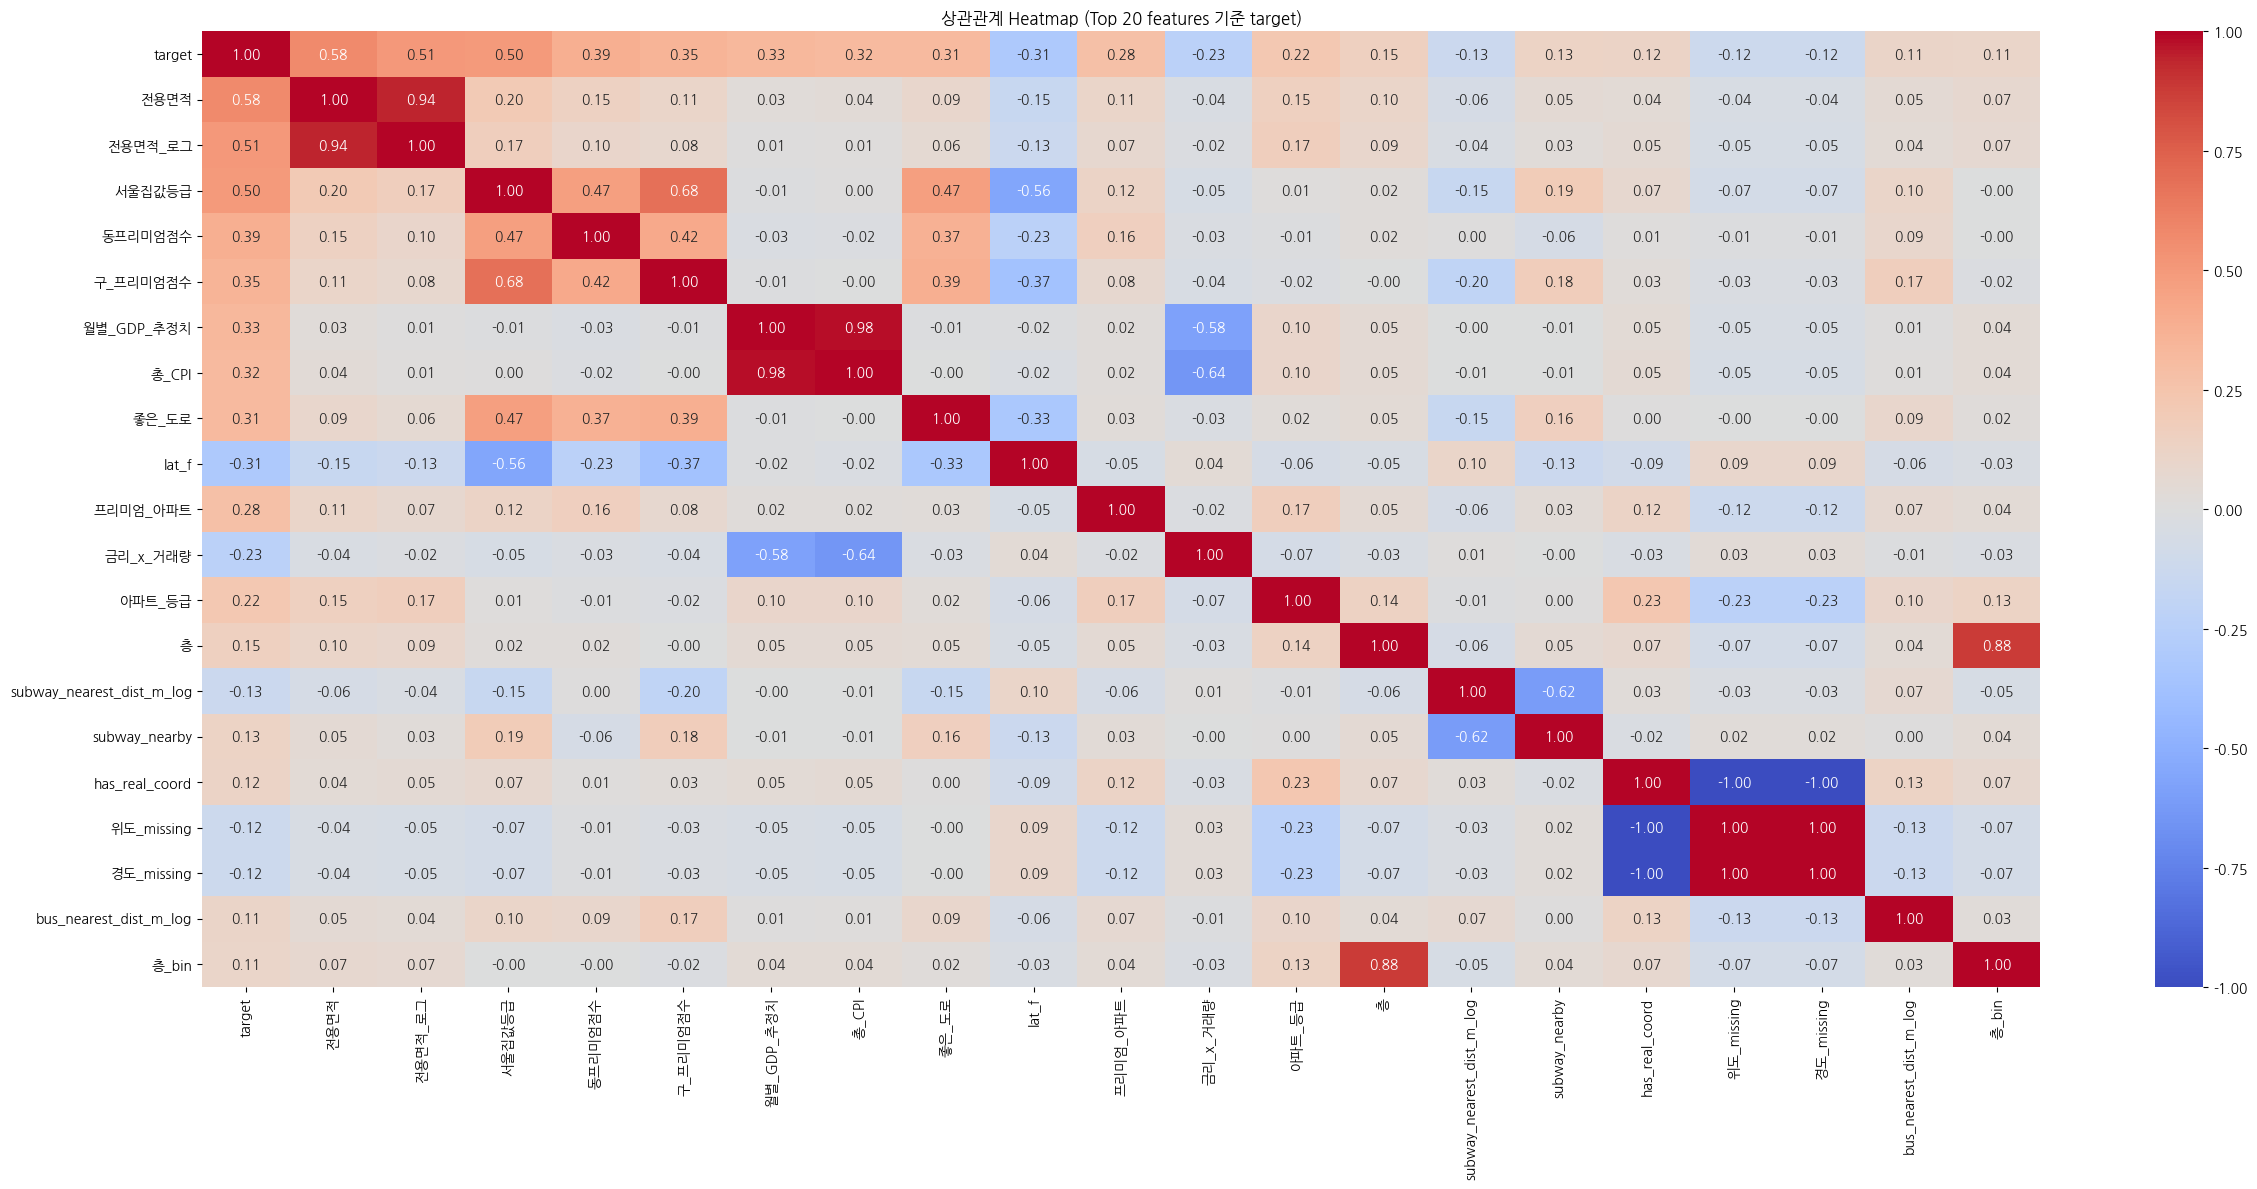

In [388]:
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
def plot_corr_heatmap(train, target_col="target", topn=20):
    """
    - train 데이터만 사용
    - 수치형 변수의 target과 상관관계 계산
    - 상위 N개 변수 + target으로 heatmap 시각화
    """
    # train만 필터링
    dtrain = train.copy()
    
    # 수치형 변수만 선택
    num_cols = dtrain.select_dtypes(include=["number"]).columns.tolist()
    if target_col in num_cols:
        pass
    else:
        num_cols.append(target_col)

    # 결측치 중앙값 대체 (상관 안정화)
    dnum = dtrain[num_cols].copy()
    dnum = dnum.fillna(dnum.median())

    # 상관계수 행렬
    corr = dnum.corr()

    # target과 상관 높은 상위 N 변수 선택
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    top_features = target_corr.head(topn+1).index.tolist()  # target 포함

    # Heatmap 그리기
    plt.figure(figsize=(1.2*len(top_features), 12))
    sns.heatmap(corr.loc[top_features, top_features], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"상관관계 Heatmap (Top {topn} features 기준 {target_col})")
    plt.tight_layout()
    plt.show()

# ======================
# 사용 예시
# ======================
plot_corr_heatmap(train, target_col="target", topn=20)

In [269]:
train.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target', '구', '동', '아파트_등급',
       '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그',
       '거래량', '금리_x_거래량', '전월비 (%)', '전년동월비', '월별_GDP_추정치', '총_CPI',
       '위도_missing', '경도_missing', 'lat_f', 'lon_f', 'has_real_coord',
       'subway_nearby', 'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log',
       '층_bin'],
      dtype='object')

In [270]:
train_origin = train.copy()
test_origin = test.copy()

In [271]:
# (선택) 면적 버킷 만들고 나서 원본 드롭
bins   = [0, 60, 85, 135, float('inf')]
labels = ['≤60','60–85','85–135','>135']
for df in (train, test):
    df['전용면적_bin'] = pd.cut(df['전용면적'], bins=bins, labels=labels, right=True)
# 원본 면적은 제거, 로그만 유지
train = train.drop(columns=['전용면적'], errors='ignore')
test  = test.drop(columns=['전용면적'],  errors='ignore')

0          60–85
1          60–85
2            ≤60
3          60–85
4          60–85
           ...  
1118817      ≤60
1118818      ≤60
1118819    60–85
1118820    60–85
1118821      ≤60
Name: 전용면적_bin, Length: 1118822, dtype: category
Categories (4, object): ['≤60' < '60–85' < '85–135' < '>135']

In [273]:
drop_list = ['위도_missing','경도_missing','subway_nearby','월별_GDP_추정치']

train.drop(drop_list,axis=1,inplace=True)
test.drop(drop_list,axis=1,inplace=True)

In [274]:
train.columns

Index(['아파트명', '계약일', '층', '건축년도', '도로명', 'target', '구', '동', '아파트_등급',
       '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그',
       '거래량', '금리_x_거래량', '전월비 (%)', '전년동월비', '총_CPI', 'lat_f', 'lon_f',
       'has_real_coord', 'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log',
       '층_bin', '전용면적_bin'],
      dtype='object')

In [275]:
test.columns

Index(['아파트명', '계약일', '층', '건축년도', '도로명', 'target', '구', '동', '아파트_등급',
       '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그',
       '거래량', '금리_x_거래량', '전월비 (%)', '전년동월비', '총_CPI', 'lat_f', 'lon_f',
       'has_real_coord', 'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log',
       '층_bin', '전용면적_bin'],
      dtype='object')

In [278]:
train

,아파트명,계약일,층,건축년도,도로명,target,구,동,아파트_등급,프리미엄_아파트,...,전월비 (%),전년동월비,총_CPI,lat_f,lon_f,has_real_coord,bus_nearest_dist_m_log,subway_nearest_dist_m_log,층_bin,전용면적_bin
0,개포6차우성,8,3,1987,언주로 3,124000,강남구,개포동,1,0,...,0.4,1.4,97.456,37.476763,127.057210,1,4.139955,7.030681,1,60–85
1,개포6차우성,22,4,1987,언주로 3,123500,강남구,개포동,1,0,...,0.4,1.4,97.456,37.476763,127.057210,1,4.139955,7.030681,1,60–85
2,개포6차우성,28,5,1987,언주로 3,91500,강남구,개포동,1,0,...,0.4,1.4,97.456,37.476763,127.057210,1,4.139955,7.030681,1,≤60
3,개포6차우성,3,4,1987,언주로 3,130000,강남구,개포동,1,0,...,0.4,0.8,97.844,37.476763,127.057210,1,4.139955,7.030681,1,60–85
4,개포6차우성,8,2,1987,언주로 3,117000,강남구,개포동,1,0,...,0.4,0.8,97.844,37.476763,127.057210,1,4.139955,7.030681,1,60–85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,12,11,1998,서오릉로21길 36,20000,은평구,구산동,1,0,...,0.4,2.5,77.362,37.612962,126.905638,1,4.389499,6.947553,2,≤60
1118818,갈현현대,25,10,1998,서오릉로21길 36,20000,은평구,구산동,1,0,...,0.1,2.0,77.436,37.612962,126.905638,1,4.389499,6.947553,2,≤60
1118819,갈현현대,31,20,1998,서오릉로21길 36,28000,은평구,구산동,1,0,...,0.1,2.0,77.436,37.612962,126.905638,1,4.389499,6.947553,3,60–85
1118820,갈현현대,15,8,1998,서오릉로21길 36,29000,은평구,구산동,1,0,...,0.6,2.3,77.878,37.612962,126.905638,1,4.389499,6.947553,2,60–85


In [281]:
if {'계약년','건축년도'}.issubset(train.columns):
    train['건물연차'] = (train['계약년'] - train['건축년도']).clip(lower=0, upper=100)
if {'계약년','건축년도'}.issubset(test.columns):
    test['건물연차'] = (test['계약년'] - test['건축년도']).clip(lower=0, upper=100)

In [282]:
train.drop('건축년도',axis=1,inplace=True)
test.drop('건축년도',axis=1,inplace=True)

In [280]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns= []
categorical_columns = []
for column in train.columns:
    if pd.api.types.is_numeric_dtype(train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['계약일', '층', '건축년도', 'target', '아파트_등급', '프리미엄_아파트', '서울집값등급', '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그', '거래량', '금리_x_거래량', '전월비 (%)', '전년동월비', '총_CPI', 'lat_f', 'lon_f', 'has_real_coord', 'bus_nearest_dist_m_log', 'subway_nearest_dist_m_log', '층_bin']
범주형 변수: ['아파트명', '도로명', '구', '동', '전용면적_bin']


In [283]:
train.drop(['계약일','층_bin','lat_f','lon_f'],axis=1,inplace=True)
test.drop(['계약일','층_bin','lat_f','lon_f'],axis=1,inplace=True)

In [284]:
continuous_columns= ['층','건축년도','계약년','동프리미엄점수','구_프리미엄점수','전용면적_로그','거래량','금리_x_거래량','전월비 (%)','전년동월비','총_CPI','bus_nearest_dist_m_log','subway_nearest_dist_m_log']
categorical_columns = ['아파트명','도로명','구','동','전용면적_bin','has_real_coord','아파트_등급','프리미엄_아파트','서울집값등급','좋은_도로']

In [285]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
set_seed(42)

In [ ]:
# 중복 확인
safe_cols, col_map = build_safe_columns(train.columns)
train.columns = safe_cols

In [289]:
train.columns

Index(['아파트명', '층', '도로명', 'target', '구', '동', '아파트_등급', '프리미엄_아파트', '서울집값등급',
       '좋은_도로', '계약년', '동프리미엄점수', '구_프리미엄점수', '전용면적_로그', '거래량', '금리_x_거래량',
       '전월비_(%)', '전년동월비', '총_CPI', 'has_real_coord', 'bus_nearest_dist_m_log',
       'subway_nearest_dist_m_log', '전용면적_bin', '건물연차'],
      dtype='object')

In [ ]:
import numpy as np

def year_weights(df, year_col="계약년", method="exp", decay=0.90,    # exp: 0.90이면 1년 전은 0.9배
                 min_w=0.5, max_w=2.0, normalize=True):
    """
    최근 연도일수록 큰 가중치. base_year = df[year_col].max()
    method="exp": w = decay ** (base_year - year)  (최근=1.0, 1년전=0.9, 2년전=0.81 …)
    """
    y = df[year_col].to_numpy()
    base = int(np.nanmax(y))
    age = base - y

    if method == "exp":
        w = decay ** np.clip(age, 0, None)
    elif method == "linear":
        # 최근=1.0, k년 이전부터 선형 감쇠 (예: k=10)
        k = 10
        w = 1.0 - np.clip(age, 0, k) / k
    else:
        raise ValueError("method must be 'exp' or 'linear'")

    # 안전장치: 클리핑 + 평균 1로 정규화(옵션)
    w = np.clip(w, min_w, max_w)
    if normalize:
        w = w * (len(w) / w.sum())
    return w

# 사용 예시
w_train = year_weights(train, year_col="계약년", method="exp", decay=0.92)  # 조금 완만한 감쇠
# LightGBM 학습 시
# model.fit(X_train, y_train, sample_weight=w_train, ...)


In [296]:
train_main = train.copy()
test_main = test.copy()

In [306]:

# year_count: 위에 준 연도-건수 테이블을 DataFrame으로 만들었다고 가정
year_count = pd.DataFrame({
    "year":[2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023],
    "count":[58767,57012,73491,44457,54513,40851,67865,85130,119891,99253,104893,81413,74696,83711,43117,12214,17548]
})

def build_year_weights(df_counts, base_year=2023, decay=0.94, power=0.5,
                       min_w=0.6, max_w=2.0, normalize=True):
    mc = df_counts["count"].max()
    w = {}
    for y, c in zip(df_counts["year"], df_counts["count"]):
        rec   = decay ** (base_year - y)              # 최근일수록 ↑
        invfq = (mc / c) ** power                     # 소표본 연도 보정
        w[y]  = rec * invfq
    # 클립
    for y in w: w[y] = np.clip(w[y], min_w, max_w)
    # 평균 1로 정규화
    if normalize:
        mean = np.mean(list(w.values()))
        for y in w: w[y] /= mean
    return w

w_map = build_year_weights(year_count)

# 행별 sample_weight 생성 (train에 '계약년'이 있다고 가정)
train["sample_weight"] = train["계약년"].map(w_map).fillna(1.0)
# LightGBM 학습 시
# model.fit(X_train, y_train, sample_weight=train["sample_weight"], ...)


In [314]:
y_train = train['target']

In [315]:
train.drop('target',axis=1,inplace=True)
test.drop('target',axis=1,inplace=True)

In [323]:
train['target'] = y_train

In [320]:
X =train.copy()
y = y_train.copy

In [326]:
train

,아파트명,층,도로명,구,동,아파트_등급,프리미엄_아파트,서울집값등급,좋은_도로,계약년,...,전월비_(%),전년동월비,총_CPI,has_real_coord,bus_nearest_dist_m_log,subway_nearest_dist_m_log,전용면적_bin,건물연차,sample_weight,target
0,개포6차우성,3,언주로 3,강남구,개포동,1,0,3.0,1,2017,...,0.4,1.4,97.456,1,4.139955,7.030681,60–85,0,0.788039,124000
1,개포6차우성,4,언주로 3,강남구,개포동,1,0,3.0,1,2017,...,0.4,1.4,97.456,1,4.139955,7.030681,60–85,0,0.788039,123500
2,개포6차우성,5,언주로 3,강남구,개포동,1,0,3.0,1,2017,...,0.4,1.4,97.456,1,4.139955,7.030681,≤60,0,0.788039,91500
3,개포6차우성,4,언주로 3,강남구,개포동,1,0,3.0,1,2018,...,0.4,0.8,97.844,1,4.139955,7.030681,60–85,0,0.951581,130000
4,개포6차우성,2,언주로 3,강남구,개포동,1,0,3.0,1,2018,...,0.4,0.8,97.844,1,4.139955,7.030681,60–85,0,0.951581,117000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,11,서오릉로21길 36,은평구,구산동,1,0,1.0,0,2007,...,0.4,2.5,77.362,1,4.389499,6.947553,≤60,0,0.641079,20000
1118818,갈현현대,10,서오릉로21길 36,은평구,구산동,1,0,1.0,0,2007,...,0.1,2.0,77.436,1,4.389499,6.947553,≤60,0,0.641079,20000
1118819,갈현현대,20,서오릉로21길 36,은평구,구산동,1,0,1.0,0,2007,...,0.1,2.0,77.436,1,4.389499,6.947553,60–85,0,0.641079,28000
1118820,갈현현대,8,서오릉로21길 36,은평구,구산동,1,0,1.0,0,2007,...,0.6,2.3,77.878,1,4.389499,6.947553,60–85,0,0.641079,29000


In [327]:
train.to_csv('train_12.csv',encoding='utf-8')
test.to_csv('test_12.csv',encoding='utf-8')

In [ ]:
from pathlib import Path
import re, csv, os, json, warnings
import numpy as np
import pandas as pd
from typing import Optional

# ---- 경로 ----
ROOT = Path("/workspace/project/upstage-ml-regression-sigma7")
DATA_RAW = ROOT / "data/raw"
DATA_PROC = ROOT / "data/processed"
REPORTS = ROOT / "notebooks/hyoentae/reports"
REPORTS.mkdir(parents=True, exist_ok=True)
(REPORTS / "tables").mkdir(parents=True, exist_ok=True)

TRAIN_CSV = DATA_RAW / "train.csv"
TEST_CSV  = DATA_RAW / "test.csv"
TRAIN_WEIGHTED_CSV = DATA_PROC / "train_weighted.csv"
COLMAP_CSV = REPORTS / "tables" / "feature_name_mapping.csv"
MODEL_PKL = ROOT / "reports" / "model_weighted.pkl"
SUBMIT_CSV = ROOT / "notebooks" / "hyoentae" / "submission.csv"  # 원하는 경로로 수정 가능

TARGET = "target"
YEAR_COL = "계약연도"
DATE_COL = "계약년월"

# ---- 랜덤 시드 고정 ----
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
set_seed(42)

# ---- 컬럼명 sanitize (LightGBM JSON 특수문자 방지) ----
def sanitize_feature_name(name: str) -> str:
    s = str(name)
    s = re.sub(r'[\n\r\t]', ' ', s)          # 제어문자 -> 공백
    s = re.sub(r'[\\\"{}\[\]:,]', '_', s)    # JSON 특수문자 -> _
    s = re.sub(r'\s+', '_', s)               # 공백 -> _
    s = re.sub(r'_+', '_', s).strip('_')     # 연속 '_' 축약 + 트림
    if s == '':
        s = 'col'
    return s

def build_safe_columns(columns):
    safe, seen, mapping = [], set(), {}
    for c in columns:
        sc = sanitize_feature_name(c)
        base, k = sc, 1
        while sc in seen:
            k += 1
            sc = f"{base}_{k}"
        seen.add(sc)
        mapping[c] = sc
        safe.append(sc)
    return safe, mapping

# ---- 안전한 CSV 로더 ----
def sniff_delimiter(sample_text: str) -> str:
    for cand in [",", "\t", "|", ";"]:
        if cand in sample_text:
            return cand
    return ","

def safe_read_csv(path: str, sep: Optional[str] = None, encodings=("utf-8","cp949")) -> pd.DataFrame:
    path = str(path)
    if sep is None:
        with open(path, "rb") as f:
            raw = f.read(256*1024)
        txt = None
        for enc in encodings:
            try:
                txt = raw.decode(enc, errors="ignore"); break
            except Exception: pass
        if txt is None:
            txt = raw.decode("utf-8", errors="ignore")
        sep = sniff_delimiter(txt)

    for enc in encodings:
        try:
            return pd.read_csv(path, engine="c", encoding=enc, sep=sep, low_memory=True, quoting=csv.QUOTE_MINIMAL)
        except Exception as e1:
            print(f"[WARN] C-engine({enc}) 실패: {e1}")
        try:
            return pd.read_csv(path, engine="python", encoding=enc, sep=sep, on_bad_lines="skip", quoting=csv.QUOTE_MINIMAL)
        except Exception as e2:
            print(f"[WARN] python-engine({enc}) 실패: {e2}")

    # 폴백: 청크
    frames = []
    for enc in encodings:
        try:
            for chunk in pd.read_csv(path, engine="python", encoding=enc, sep=sep, on_bad_lines="skip",
                                     quoting=csv.QUOTE_MINIMAL, chunksize=500_000):
                frames.append(chunk)
            if frames:
                return pd.concat(frames, ignore_index=True)
        except Exception as e3:
            print(f"[WARN] chunk read 실패({enc}): {e3}")
    raise RuntimeError(f"safe_read_csv 실패: {path}")


In [ ]:
def ensure_year(df: pd.DataFrame) -> pd.DataFrame:
    if YEAR_COL not in df.columns:
        if DATE_COL in df.columns:
            s = df[DATE_COL].astype(str).str.replace(r"\D","",regex=True).str[:6] + "01"
            dt = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
            df[YEAR_COL] = dt.dt.year
        else:
            raise ValueError(f"'{YEAR_COL}'도 없고 '{DATE_COL}'도 없어 연도 파생을 할 수 없습니다.")
    return df

def compute_year_weights(df: pd.DataFrame) -> dict:
    freq = df[YEAR_COL].value_counts(dropna=True).sort_index()
    med = np.median(freq.values)
    weights = med / freq
    return weights.to_dict()

def attach_weights(df: pd.DataFrame, wmap: dict) -> pd.DataFrame:
    out = df.copy()
    out["sample_weight"] = out[YEAR_COL].map(wmap).astype(float).fillna(1.0)
    return out

# ----- 실행 -----
train = safe_read_csv(TRAIN_CSV)
train = ensure_year(train)
wmap = compute_year_weights(train)
train_w = attach_weights(train, wmap)

DATA_PROC.mkdir(parents=True, exist_ok=True)
train_w.to_csv(TRAIN_WEIGHTED_CSV, index=False)
print(f"[OK] 저장: {TRAIN_WEIGHTED_CSV}, shape={train_w.shape}, sample_weight range=({train_w['sample_weight'].min():.3f} ~ {train_w['sample_weight'].max():.3f})")


In [ ]:
# sanitize 동일 재현 + category 변환 + 컬럼 순서 맞추기
df = pd.read_csv(TRAIN_WEIGHTED_CSV, low_memory=False)
y = df[TARGET]
X = df.drop(columns=[TARGET, "sample_weight"])

# 매핑 파일 사용해 rename
colmap_df = pd.read_csv(COLMAP_CSV)
mapping = dict(zip(colmap_df["original"], colmap_df["sanitized"]))
X = X.rename(columns={k:v for k,v in mapping.items() if k in X.columns})

# 연도 파생 보장
if YEAR_COL not in X.columns and DATE_COL in df.columns:
    s = df[DATE_COL].astype(str).str.replace(r"\D","",regex=True).str[:6] + "01"
    X[YEAR_COL] = pd.to_datetime(s, format="%Y%m%d", errors="coerce").dt.year

# object -> category
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X[c] = X[c].astype("category")

# 모델/피처 순서 맞추기
import joblib
model = joblib.load(MODEL_PKL)
feat_names = model._Booster.feature_name()
for f in feat_names:
    if f not in X.columns:
        X[f] = 0
X = X[feat_names]

# 마스크
mask1519 = (X[YEAR_COL] >= 2015) & (X[YEAR_COL] <= 2019)
mask2023 = (X[YEAR_COL] >= 2020) & (X[YEAR_COL] <= 2023)

from sklearn.metrics import mean_squared_error, r2_score
def seg_eval(mask, name):
    if mask.sum()==0:
        print(f"{name}: 데이터 없음"); return
    p = model.predict(X[mask])
    rmse = mean_squared_error(y[mask], p, squared=False)
    r2 = r2_score(y[mask], p)
    print(f"{name}: RMSE={rmse:.2f}  R2={r2:.4f}  (n={mask.sum()})")

seg_eval(mask1519, "Validation 2015-2019")
seg_eval(mask2023, "Test-like 2020-2023")

In [ ]:
# 테스트 로딩
test = safe_read_csv(TEST_CSV)

# 학습과 동일한 sanitize 적용
test_cols = test.columns.tolist()
safe_cols, _ = build_safe_columns(test_cols)
test_san = test.copy()
test_san.columns = safe_cols

# 연도 파생(필요 시)
if YEAR_COL not in test_san.columns and DATE_COL in test_san.columns:
    s = test_san[DATE_COL].astype(str).str.replace(r"\D","",regex=True).str[:6] + "01"
    test_san[YEAR_COL] = pd.to_datetime(s, format="%Y%m%d", errors="coerce").dt.year

# object -> category
obj_cols_test = test_san.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols_test:
    test_san[c] = test_san[c].astype("category")

# 학습 모델/피처 순서 맞추기
import joblib
model = joblib.load(MODEL_PKL)
feat_names = model._Booster.feature_name()
# 누락 피처는 0으로, 초과 피처는 드랍
for f in feat_names:
    if f not in test_san.columns:
        test_san[f] = 0
X_test = test_san[feat_names]

# 예측
pred_test = model.predict(X_test)

# 제출 파일 생성 (대회 포맷에 맞게 컬럼명 수정 필요할 수 있음)
# 예: sample_submission.csv의 ID 컬럼명이 'id'라고 가정
submit = pd.DataFrame({  # 실제 대회에서 주어진 id 컬럼으로 교체하세요
    "target": pred_test.round().astype(int)
})
SUBMIT_CSV.parent.mkdir(parents=True, exist_ok=True)
submit.to_csv(SUBMIT_CSV, index=False, encoding="utf-8")
print(f"[OK] 제출 파일 저장 -> {SUBMIT_CSV}  (rows={len(submit)})")


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
def medape(y_true, y_pred):
    ape = np.abs((y_pred - y_true) / np.clip(np.abs(y_true), 1e-8, None))
    return np.median(ape)

# 전체/구간별
p_all = model.predict(X)
print("ALL:   MAPE={:.4f}  MedAPE={:.4f}".format(
    mean_absolute_percentage_error(y, p_all), medape(y, p_all)
))
if mask1519.sum()>0:
    p_1519 = model.predict(X[mask1519])
    print("2015-19: MAPE={:.4f}  MedAPE={:.4f}".format(
        mean_absolute_percentage_error(y[mask1519], p_1519), medape(y[mask1519], p_1519)
    ))
if mask2023.sum()>0:
    p_2023 = model.predict(X[mask2023])
    print("2020-23: MAPE={:.4f}  MedAPE={:.4f}".format(
        mean_absolute_percentage_error(y[mask2023], p_2023), medape(y[mask2023], p_2023)
    ))
